In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting the vector field

In [3]:
X, Y = np.meshgrid(np.arange(-1.5, 1.5, .15), np.arange(-1, 1, .15))

U = -0.05*X + Y
V = -X - 0.05*Y 

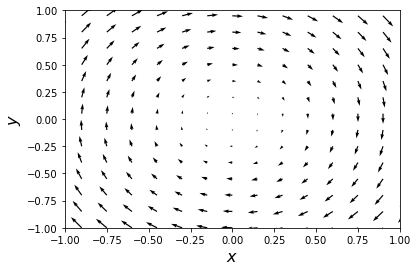

In [4]:
plt.figure()
plt.quiver(X, Y, U, V, units='width', edgecolor='k')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(r"$x$",fontsize=16)
plt.ylabel(r"$y$",fontsize=16)
plt.show()

# Solve IVP with RK45

In [5]:
from scipy.integrate import solve_ivp

In [6]:
A = np.array([
    [-0.05, 1.],
    [-1., -0.05]
])
x0 = np.array([1,0])

In [7]:
f = lambda t,x: np.dot(A,x)

In [8]:
T = 40
t = np.linspace(0, T, 500)

In [9]:
sol = solve_ivp(f, (0,T), x0, t_eval = t, method='RK45')

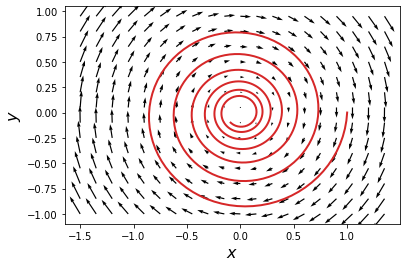

In [10]:
plt.figure()
plt.quiver(X, Y, U, V, units='width', edgecolor='k')
plt.plot(sol.y[0],sol.y[1], color="tab:red", linewidth=2.)
plt.xlabel(r"$x$",fontsize=16)
plt.ylabel(r"$y$",fontsize=16)
plt.show()

# Using neural ODEs to learn a dynamical system

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

In [40]:
true_x0 = torch.tensor([[1., 0.]])
t = torch.linspace(0., T, 500)
true_A = torch.tensor([[-0.05, 1.0], [-1.0, -0.05]]).T

Define right-hand side of ODE

In [41]:
class Lambda(nn.Module):

    def forward(self, t, y):
        
        return torch.mm(y, true_A)

Define neural ODE

In [42]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

Generate batches based on observed trajectory

In [43]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_x0 = true_x[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_x = torch.stack([true_x[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_x0, batch_t, batch_x

In [44]:
true_x = odeint(Lambda(), true_x0, t, method='dopri5')

Iter 0010 | Total Loss 0.349150
Iter 0020 | Total Loss 0.289193
Iter 0030 | Total Loss 0.119159
Iter 0040 | Total Loss 0.012621
Iter 0050 | Total Loss 0.024901
Iter 0060 | Total Loss 0.019063
Iter 0070 | Total Loss 0.020963
Iter 0080 | Total Loss 0.034926
Iter 0090 | Total Loss 0.034695
Iter 0100 | Total Loss 0.031025


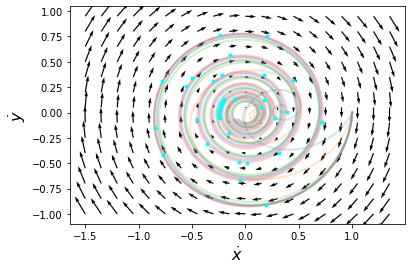

In [45]:
data_size = 500
batch_size = 30
batch_time = 10

func = ODEFunc()

optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

plt.figure()
plt.quiver(X, Y, U, V, units='width', edgecolor='k')
batch_x0, batch_t, batch_x = get_batch()

plt.plot(batch_x0.detach().numpy()[:,0,0],batch_x0.detach().numpy()[:,0,1], '.', color='aqua', zorder=10)
plt.plot(batch_x.detach().numpy()[:,0,0,0],batch_x.detach().numpy()[:,0,0,1], '.', color='aqua', zorder=10)
    
for itr in range(1, 101):
    optimizer.zero_grad()
    pred_x = odeint(func, batch_x0, batch_t)
    loss = torch.mean(torch.abs(pred_x - batch_x))
    loss.backward()
    optimizer.step()

    if itr % 10 == 0:
        with torch.no_grad():
            pred_x = odeint(func, true_x0, t)
            loss = torch.mean(torch.abs(pred_x - true_x))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            itr += 1
           
            plt.plot(pred_x.detach().numpy()[:, 0, 0],pred_x.detach().numpy()[:, 0, 1], linewidth=2., alpha = 0.2)

plt.xlabel(r"$\dot{x}$",fontsize=16)
plt.ylabel(r"$\dot{y}$",fontsize=16)
plt.savefig("training_outcome.png",dpi=300)
plt.show()